<a href="https://colab.research.google.com/github/eljimenezj/Prueba_TG/blob/main/1.%20Entrega_Prueba_TG_ELJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de imagenes utilizando Deep Learning - Una aplicación de Hand Signs

En este libro se desarrolla toda la solución para una prueba tecnica que consiste en la creación de un modelo que permita realizar clasificación de imagenes, puntualmente imagenes con números del 0 al 5 representados con la mano humana. Este modelo es posteriormente desplegado en `streamlit` para que pueda ser utilizado por un usuario final.

Finalmente, este desarrollo se presenta como parte de una prueba técnica de Trascender Global 


Presentado por

* Edgar Leandro Jimenez Jaimes - eljimenezj@gmail.com

Febrero 2021



Este libro se encuentra organizado de la siguiente manera:

1. Lectura y estructuración del pipeline de los datos.
2. Estructuración del Data Augmentation utilizando ImageDataGenerator
3. Entrenamiento de red neuronal preentrenada:ResNet50
4. Graficas de desempeño
5. Prueba de desempeño en los datos de testeo

In [ ]:
# Vamos a cargar las Librerias necesarias para preprocesar

from PIL import Image
import pandas as pd
import glob
import re
import numpy as np
import imutils
import time
import os
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt

#import seaborn as sn  
#import datetime
#from tqdm import tqdm
#from pathlib import Path

import tensorflow as tf
import keras_preprocessing
from keras.applications import densenet  
from keras import regularizers  
from keras import backend as K  
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential, Model, load_model  
from keras.applications.resnet50 import preprocess_input 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

import warnings
warnings.filterwarnings('ignore')


# 1. Lectura y estructuración del rutas

In [ ]:
'''
 Ahora realizamos la autenticacion necesaria para Google Drive
 e ir a buscar los datos almacenados, esto debe realizare cada vez
 que se reinicie el Colab 
'''

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
 Definición de algunos parametros de entrada que serviran de control durante el notebook. Las variables
 img_width, img_height configuran el ancho y alto en pixeles que se van a tomar de las imagenes de entradas
 nb_train_samples se refiere al numero inicial de muestras en train, nb_validation_samples y nb_test_samples
 al numero de imagenes en validacion y test respectivamente. Y el batch_size será el encargado de controlar
 un numero de imagenes dado, es decir el valor configurado se refiere a un numero de imagenes
'''

img_width, img_height = 64, 64  
nb_train_samples = 864             
nb_validation_samples = 216        
nb_test_samples = 120
batch_size = 32                    


'''
 Hacemos definición de los directorios donde se encuentra la información, estas imagenes se encuentran
 almacenadas por carpetas y divididas en las etiquetas de los numeros 1,2,3,4 y 5 respectivamente
'''

path_base = '/content/drive/My Drive/Prueba_Trascender/Datos'
train_data_dir = path_base + '/train_signs'  
validation_data_dir = path_base + '/val_signs'
test_data_dir = path_base + '/test_signs'

# 2. Estructuración del Data Augmentation utilizando ImageDataGenerator
A continuación se van a configurar los generadores de datos que nos van a servir para establecer los datos de entrenamiento, de validación y de testeo. Para esta tarea se utiliza `ImageDataGenerator` la cual una función creada en Keras que genera pilas de imágenes con datos crecientes en tiempo real.

In [ ]:

'''
Estructuramos el DataAugmentacion que se va a utilizar durante el entrenamiento de las imagenes para esto se utiliza 
ImageDataGenerator como se menciono anteriormente, la cual se configuro de la siguiente manera:

--> horizontal_flip:  Ejecuta vueltas a las imagenes (efecto similar a un espejo)

--> rotation_range: Rotaciónn de la imagen en el rango [0,90]

--> brightness_range: Cambia los niveles de luminosidad de la imagen

--> : Realiza Zoom a la imagen (Si < 1 acerco, = 1 Misma imagen, > 1 Alejo)

'''

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,                                        
    rotation_range=90,                                           
    brightness_range=[0.2,0.8],                                  
    zoom_range=[0.8,1.2])                                        

'''
Ahora instanciamos lo que se utilizará como datos de entranmiento y le damos el directorio donde se encuentran
las imagenes, teniendo en cuenta el train.datagen anterior que será el encargado de realizar el data augmentation
'''
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,                                             
    target_size=(img_width, img_height),                            
    batch_size=batch_size,                                      
    shuffle = False,                                                               
    class_mode='categorical')                                         

'''
Ahora instanciamos lo que se utilizará como datos de validación y le damos el directorio donde se encuentran
las imagenes. Para este caso no se realiza el data augmentation, este se emplea en entrenamiento.
'''

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size, shuffle = False,
    class_mode='categorical') 


'''
Ahora instanciamos lo que se utilizará como datos de test y le damos el directorio donde se encuentran
las imagenes. Para este caso no se realiza el data augmentation, este se emplea en entrenamiento.
'''
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(  
    test_data_dir,
    target_size=(img_width, img_height), 
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

Found 864 images belonging to 6 classes.
Found 216 images belonging to 6 classes.
Found 120 images belonging to 6 classes.


# 3. Estructuracion y entrenamiento de red neuronal preentrenada:ResNet50

Se va a utilizar la arquitectura de la red convolucional resnet50 de `keras`, para esto se configura capa de salida ajustada a nuestra necesidad de las clases. Adicionalmente se adicionan callbacks para el entrenamiento y toda la configuracion necesaria en el compilado, posteriormente se entrena.

In [ ]:
'''
Importamos la red neuronal resnet50 desde keras sin incluir la capa de salida,
a continuacion añadimos la capa de salida propia que utilizara una funcion sigmoide
para el problema de clasificacion binaria. 
'''

import tensorflow as tf
K.clear_session()

# Instacia del modelo y configuración
base_model = tf.keras.applications.resnet50.ResNet50(weights= 'imagenet', 
                                            include_top=False,              
                                            input_shape= (64,64,3)) # Tamaño de imagenes

x = base_model.output                                               
x = tf.keras.layers.GlobalAveragePooling2D()(x)          # reduce dim del tensor                    
x = tf.keras.layers.Dropout(0.5)(x)                      # regularizacion

predictions = tf.keras.layers.Dense(6,                   # numero de clases           
                    activation= 'softmax')(x)

'''
Unimos la capa de entrada que es resnet50 (o sus pesos) con la capa de salida diseñada anteriormente
'''
model = tf.keras.models.Model(inputs = base_model.input, 
                              outputs = predictions)


'''
Una vez construida construida la arquitectura de la red convolucional resnet50
debemos compilar el modelo, en este paso definimos que función de perdida vamos a utilizar, que optimizador 
y que metricas queremos medir. Para esta modelación se utilizói lo siguiente

--> Función de perdida (loss): categorical_crossentropy: La función de pérdida de crossentropía categorical se usa en decisiones con mas de dos clases.
La pérdida le dice cuán equivocadas son las predicciones del modelo: https://keras.io/api/losses/probabilistic_losses/#categorical_crossentropy-function

--> Optimizador: Adam con tasa de aprendizaje 0.0001: Adam es un método de descenso de gradiente estocástico que se basa en la estimación adaptativa de 
los momentos de primer y segundo orden: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

--> Metrica: AUC: (Área bajo la curva) el cual mide  el “área o espacio” bajo la curva ROC y tiene por objeto medir la certeza de un modelo a la 
hora de realizar predicciones (toma valor de 1 cuándo se es 100% preciso) siendo invariable al umbral de clasificación.
https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
'''

model.compile(loss='categorical_crossentropy',                                      
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),         
                metrics=[tf.keras.metrics.AUC()])                                                             

# Observemos la arquitectura del modelo resnet50
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
'''
Ahora se va a instanciar dos argumentos que nos van ayudar a prevenir overfitting
por un lado el EarlyStopping que nos permite parar el entrenamiento si no observa mejoria en los entranamientos
y el ModelCheckPoint que nos ayudara a guardar el mejor modelo de acuerdo a un argumento dado por el usuario
'''


keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0001),
      ModelCheckpoint('Bestmodel.h5', monitor='val_loss', save_best_only=True, mode='min')
]

'''
Una vez tenemos lista la arquitectura, compilado y las funciones callbacks del modelo, procedemos a realiza el entrenamiento
 mediante el metodo fit_generator en donde se le define cuales son los datos de entrada, el numero de epocas (# numero de veces 
que la red pasa por los datos) y cuales son los datos de validacion
'''
historia = model.fit_generator(train_generator,                             
                                  epochs=200,                            
                                  validation_data=validation_generator,      
                                  verbose=1,
                                  workers=1,
                                  callbacks=keras_callbacks,
                                  use_multiprocessing = False) 

Epoch 1/200
27/27 [==============================] - 11s 161ms/step - loss: 3.1690 - auc: 0.4577 - val_loss: 3.3669 - val_auc: 0.5065
Epoch 2/200
27/27 [==============================] - 3s 114ms/step - loss: 2.7139 - auc: 0.5141 - val_loss: 2.6143 - val_auc: 0.5057
Epoch 3/200
27/27 [==============================] - 3s 114ms/step - loss: 2.5916 - auc: 0.5285 - val_loss: 2.3179 - val_auc: 0.5026
Epoch 4/200
27/27 [==============================] - 3s 113ms/step - loss: 2.4505 - auc: 0.5413 - val_loss: 2.0354 - val_auc: 0.5425
Epoch 5/200
27/27 [==============================] - 3s 111ms/step - loss: 2.3733 - auc: 0.5610 - val_loss: 1.8363 - val_auc: 0.6062
Epoch 6/200
27/27 [==============================] - 3s 110ms/step - loss: 2.1932 - auc: 0.5752 - val_loss: 1.8850 - val_auc: 0.6168
Epoch 7/200
27/27 [==============================] - 3s 115ms/step - loss: 2.0925 - auc: 0.5921 - val_loss: 1.8729 - val_auc: 0.6130
Epoch 8/200
27/27 [==============================] - 3s 115ms/step -

# 4. Graficas de desempeño del entrenamiento

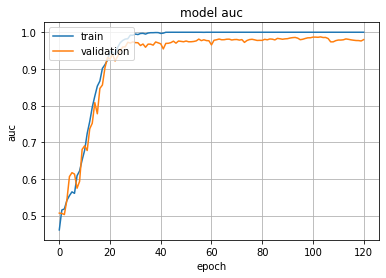

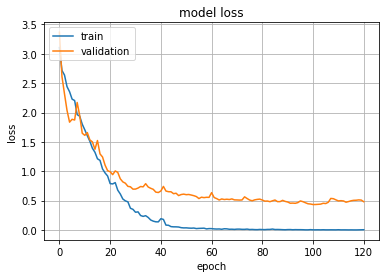

In [ ]:
'''
Para evaluar como ha sido el desempeño del modelo realizamos un par de graficos
que nos muestran como se comporto la metrica AUC, tanto del conjunto de entrenamiento
como de validacion, durante las epocas en que se entreno el modelo.

Como segunda grafica observamos el comportamiento de la funcion de costo, al igual que el 
auc, para train y validacion durante todas las epocas
'''
# Grafica 1: Comportamiento desempeño AUC 
plt.plot(historia.history['auc'])
plt.plot(historia.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

# Grafica 2: Comportamiento funcion de perdida
plt.plot(historia.history['loss'])
plt.plot(historia.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

# 5. Prueba de desempeño en los datos de testeo

In [ ]:
'''
Ahora vamos a realizar las predicciones para los datos de test y observemos como se comporta
el modelo en terminos de funcion de perdida y desempeño
'''
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples,workers=0)

loss, acc = model.evaluate_generator(test_generator, steps=nb_samples, verbose=0)
loss, acc

(0.4506300687789917, 0.9836388826370239)